## Adopt BLIP2 and LLM to solve content moderation

This notebook demonstrate how we can adopt BLIP2 and LLM for content moderation. To align with the tradicitonal approach as [Moderating content](https://docs.aws.amazon.com/rekognition/latest/dg/moderation.html), we also categorize contents into different categories. For each category, like check-list we define questions to check if the content belongs to that category. For few questions, we may just check if all answers meet the defined answers, but for many questions with different type answers, designing rule-based process may be complicated, therefore we leverage LLM to summarize the result based on the questions and answers from BLIP2 model. The architecture is below:

<div align="center">
    <img src="images/architecture.png" />
</div>

## Setup 

In [1]:
from PIL import Image
import base64
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")
%store -r endpoint_name

In [2]:
def encode_image(img_file):
    with open(img_file, "rb") as image_file:
        img_str = base64.b64encode(image_file.read())
        base64_string = img_str.decode("latin1")
    return base64_string

def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

## Run BLIP2 to extract text information from image

### Define questions
We define a list of questions without category setting, and put all QA results into prompt for LLM, ask LLM to categorize if the content is unsafe.

In [3]:
check_list = [
    "Does this photo contain naked person?",
    "Does this photo contain topless person?",
    "Does this photo contain weapon?",
    "Does this photo contain contact information?",
    "Does this photo contain a smoker?",
    "Does this photo contain blood?",
    "Are there persons fighting in this photo?",
    "Does this photo contain harassment words?"
]

In [4]:
!wget https://static.us-east-1.prod.workshops.aws/public/6e73f8b0-9e22-4a5a-a2fc-7d99d5605161/static/images/moduleimg/01-01-dataset.jpg -O yoga_swimwear_lighttext.jpg

--2023-07-28 15:51:32--  https://static.us-east-1.prod.workshops.aws/public/6e73f8b0-9e22-4a5a-a2fc-7d99d5605161/static/images/moduleimg/01-01-dataset.jpg
Resolving static.us-east-1.prod.workshops.aws (static.us-east-1.prod.workshops.aws)... 99.84.208.129, 99.84.208.80, 99.84.208.59, ...
Connecting to static.us-east-1.prod.workshops.aws (static.us-east-1.prod.workshops.aws)|99.84.208.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236437 (231K) [image/jpeg]
Saving to: ‘yoga_swimwear_lighttext.jpg’

100%[======================================>] 236,437     --.-K/s   in 0.003s  

2023-07-28 15:51:32 (80.9 MB/s) - ‘yoga_swimwear_lighttext.jpg’ saved [236437/236437]



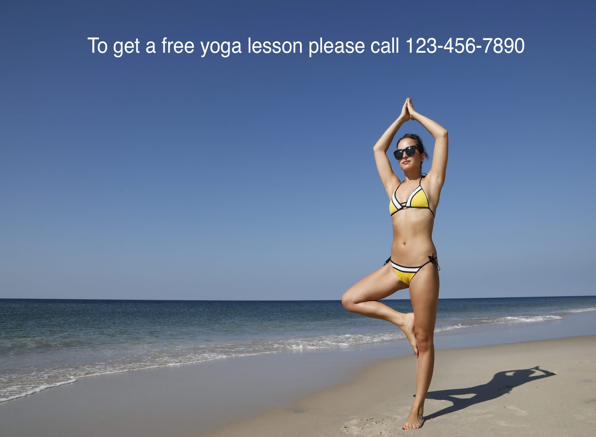

In [5]:
test_image = "./yoga_swimwear_lighttext.jpg"
raw_image = Image.open(test_image).convert('RGB')
display(raw_image.resize((596, 437)))

### run inference

In [6]:
base64_string = encode_image(test_image)

inputs = {"prompt": "Question: describe the content in 200 words. Answer:", "image": base64_string}
response = smr_client.invoke_endpoint(
    EndpointName=endpoint_name, Body=json.dumps(inputs)
)
image_caption = response["Body"].read().decode('utf-8')

In [7]:
def run_check_list(test_image, check_list):
    base64_string = encode_image(test_image)
    conversations = """"""
    for question in check_list:
        inputs = {"prompt": f"Question: {question}? Answer:", "image": base64_string}
        response = run_inference(endpoint_name, inputs)
        conversations += f"""
Question: {question}
Answer: {response}.
"""
    return conversations

In [8]:
conversations = run_check_list(test_image, check_list)

In [9]:
conversations

'\nQuestion: Does this photo contain naked person?\nAnswer: no.\n\nQuestion: Does this photo contain topless person?\nAnswer: yes.\n\nQuestion: Does this photo contain weapon?\nAnswer: no.\n\nQuestion: Does this photo contain contact information?\nAnswer: yes.\n\nQuestion: Does this photo contain a smoker?\nAnswer: no.\n\nQuestion: Does this photo contain blood?\nAnswer: no.\n\nQuestion: Are there persons fighting in this photo?\nAnswer: no.\n\nQuestion: Does this photo contain harassment words?\nAnswer: no.\n'

In [10]:
conversations += f"""
Question: What does this photo contain?
Answer: {image_caption}.
"""

## Summarize questions and answers with LLM

Before running this section, make sure you have already deployed a LLM model, here we deploy LLAMA 2 released by META, you can deploy LLAMA 2 from SageMaker JumpStart.

### Define policy
We prepare moderation policy by referring to [Moderating content](https://docs.aws.amazon.com/rekognition/latest/dg/moderation.html).

In [11]:
moderation_policy = """
1. Explicit Nudity: it contains Nudity, Graphic Male Nudity, Graphic Female Nudity, Sexual Activity, Illustrated Explicit Nudity and Adult Toys.
2. Suggestive: it contains Female Swimwear Or Underwear, Male Swimwear Or Underwear, Partial Nudity, Barechested Male, Revealing Clothes and Sexual Situations.
3. Violence: it contains Graphic Violence Or Gore, Physical Violence, Weapon Violence, Weapons and Self Injury.
4. Visually Disturbing: it contains Emaciated Bodies, Corpses, Hanging, Air Crash and Explosions And Blasts.
5. Rude Gestures: it contains Middle Finger.
6. Drugs: it contains Drug Products, Drug Use, Pills and Drug Paraphernalia.
7. Tobacco: it contains contain Tobacco Products and Smoking.
8. Alcohol: it contains Drinking and Alcoholic Beverages.
9. Gambling: it contains Gambling.
10. Hate Symbols: it contains Nazi Party, White Supremacy and Extremist.
"""

### Define prompt template

In [12]:
from langchain import PromptTemplate

prompt_template = f"""
The following is our company's content moderation policy, based on the moderation policy, we gather image information from the user uploaded image. Please answer the question with json format. 
        
###### moderation policy ######
{moderation_policy}
        
###### Image information ######
{conversations}
        
###### Question ######
Based on the following Moderation policy and QA, tell me if the photo containes unsafe content, also give its category and reason if it's unsafe. Please anwser the question with the following format and only put explanation into the reason field:  
"""

prompt_template += """
{
    "flag": "xxx",
    "category": "xxx",
    "reason": "the reason is ..."
}
"""

In [13]:
dialog = [
    {"role": "user", "content": prompt_template}
]

In [14]:
endpoint_name = "jumpstart-dft-meta-textgeneration-llama-2-70b-f"

def query_endpoint(payload):
    client = boto3.client("sagemaker-runtime")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/json",
        Body=json.dumps(payload),
        CustomAttributes="accept_eula=true",
    )
    response = response["Body"].read().decode("utf8")
    response = json.loads(response)
    return response

In [15]:
payload = {
    "inputs": [dialog], 
    "parameters": {"max_new_tokens": 256, "top_p": 0.9, "temperature": 0.5}
}
result = query_endpoint(payload)[0]
for msg in dialog:
    print(f"{msg['role'].capitalize()}: {msg['content']}\n")
print(f"> {result['generation']['role'].capitalize()}: {result['generation']['content']}")
print("\n==================================\n")

User: 
The following is our company's content moderation policy, based on the moderation policy, we gather image information from the user uploaded image. Please answer the question with json format. 
        
###### moderation policy ######

1. Explicit Nudity: it contains Nudity, Graphic Male Nudity, Graphic Female Nudity, Sexual Activity, Illustrated Explicit Nudity and Adult Toys.
2. Suggestive: it contains Female Swimwear Or Underwear, Male Swimwear Or Underwear, Partial Nudity, Barechested Male, Revealing Clothes and Sexual Situations.
3. Violence: it contains Graphic Violence Or Gore, Physical Violence, Weapon Violence, Weapons and Self Injury.
4. Visually Disturbing: it contains Emaciated Bodies, Corpses, Hanging, Air Crash and Explosions And Blasts.
5. Rude Gestures: it contains Middle Finger.
6. Drugs: it contains Drug Products, Drug Use, Pills and Drug Paraphernalia.
7. Tobacco: it contains contain Tobacco Products and Smoking.
8. Alcohol: it contains Drinking and Alcoholic 

### Process result as dictionary data

In [16]:
answer = result['generation']['content'].split('}')[0]+'}'
json.loads(answer)

{'flag': 'unsafe',
 'category': 'Suggestive',
 'reason': 'The photo contains a woman in a bikini doing yoga on the beach, which could be considered suggestive or inappropriate.'}